# Inpainting Experiment with ViT Transformer

## Dataset

In [1]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from vit.datasets import SingleImageDataset

ds = SingleImageDataset(transform=transforms.ToTensor(), target_transform=transforms.ToTensor())
dl = DataLoader(ds, batch_size=4, num_workers=2)

## Create model

In [2]:
from matplotlib import pyplot as plt
from torch import nn


# custom loss function

class PatchedLoss:

    def __init__(self, patch_coords, loss_fn=nn.MSELoss()):
        self.patch_coords = patch_coords

        self.loss = loss_fn

    def __call__(self, targets, outputs):
        x_min, y_min, h, w = self.patch_coords

        patch = torch.ones(1, 1, *outputs.shape[2:], dtype=torch.bool, device=outputs.device)
        patch[0, :, x_min:x_min+h, y_min:y_min+w] = 0
        self.patch = patch  # hack

        return self.loss(targets * patch, outputs * patch)

In [3]:
from vit.slotted_models import HourglassViT
import torch

patch_size = (16, 16)

device = torch.device('cuda')

model = HourglassViT(
        image_size=ds.image_size,
        patch_size=patch_size,
        num_classes=10,
        dim=1024,
        depth=6,
        heads=16,
        mlp_dim=2048,
        dropout=0.1,
        emb_dropout=0.1).float().to(device)

criterion = PatchedLoss([200, 400, 200, 200])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model

In [65]:
from tqdm import trange

model.train()

train_loss = []

epoch_progress = trange(100)
for epoch in epoch_progress:
    epoch_progress.set_description(f'Epoch {epoch}')
    running_loss = 0.
    running_count = 0

    for inputs, outputs in dl:
        optimizer.zero_grad()

        pred_outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), pred_outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_count += inputs.size(0)

        epoch_progress.set_postfix({
            'train loss': f'{running_loss / running_count:.3f}'
        })

    train_loss.append(running_loss / running_count)
    torch.save(model.state_dict(), f'checkpoints/model_checkpoint-{epoch}.pt')

Epoch 13:  13%|█▎        | 13/100 [04:31<30:14, 20.85s/it, train loss=750.131] 


KeyboardInterrupt: 

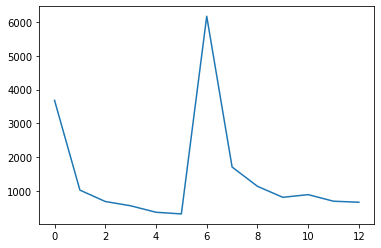

5


In [66]:
plt.plot(train_loss)
plt.show()
print(np.argmin(np.array(train_loss)))

In [4]:
model.load_state_dict(torch.load('checkpoints/model_checkpoint-5.pt'))

<All keys matched successfully>

tensor(False) tensor(True)


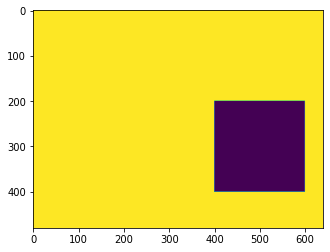

In [29]:
patch = criterion.patch.detach().cpu()

patch_image = patch[0, ...].permute((1, 2, 0))
plt.imshow(patch_image)
plt.show()

## Evaluation

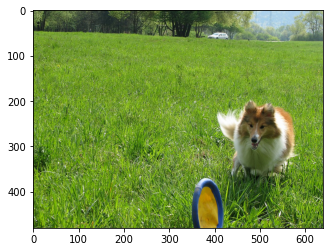

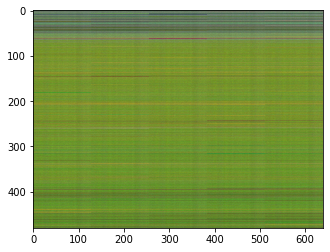

tensor(15.7566) tensor(188.2429)


In [6]:
test_dl = DataLoader(ds)
for test_input, test_image in test_dl:
    pred_image = model(test_input.to(device)).detach().cpu()

    plt.imshow(test_image[0, ...].permute((1, 2, 0)) / 255)
    plt.show()

    #plt.imshow((criterion.patch.detach().cpu() * test_image)[0, ...].permute((1, 2, 0)) / 255)
    #plt.show()

    plt.imshow(pred_image[0, ...].permute((1, 2, 0)) / 255)
    plt.show()
    print(pred_image.min(), pred_image.max())
    
    break